# Lesson 13: Going Deeper with Diffusion Models

## The Plan

- Load a diffusers pipeline and generate an image

- Sampling loop with a new sampler (plus DDIM explanation?)

- Fine-tune on a new dataset

- Guide with a loss or two (start simple, then CLIP)

- Condition on a class 

- Classifier-free guidance

- Latent Diffusion Model

- Progressive Distillation




In [1]:
from diffusers import DDPMPipeline

In [2]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256");
image_pipe.to("cuda");

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/790 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1


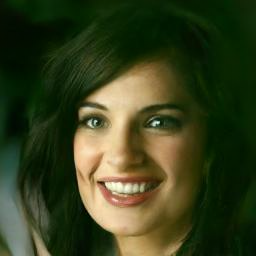

In [3]:
images = image_pipe().images # Forward method does all the magic (slowly)
print(len(images))
images[0]

In [4]:
image_pipe.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.4.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "num_train_timesteps": 1000,
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [5]:
image_pipe.unet.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

Using custom data configuration huggan--smithsonian_butterflies_subset-7665b1021a37404c
Reusing dataset parquet (/root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


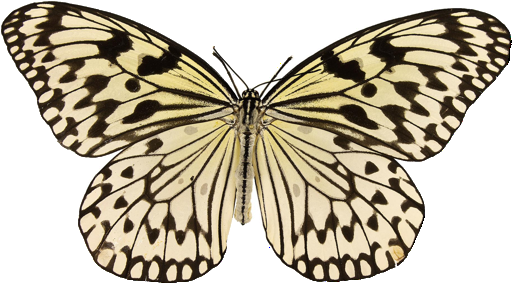

In [6]:
from datasets import load_dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
dataset[0]['image']

In [7]:
import torch
from torchvision import transforms

image_size = 256
batch_size = 4

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Parameter 'transform'=<function transform at 0x7f2ce40cc0d0> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [8]:
# Training loop
import torch.nn.functional as F
from tqdm.auto import tqdm
device = 'cuda'
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=2e-5)

losses = []

for epoch in range(5):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch['images'].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, image_pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
        
        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]
        
        # Compare the prediction with the actual noise:
        loss = F.mse_loss(noise_pred, noise) # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)
        
        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

    print(epoch, sum(losses[-len(train_dataloader):])/len(train_dataloader))

  0%|          | 0/250 [00:00<?, ?it/s]

0 0.016021831180201843


  0%|          | 0/250 [00:00<?, ?it/s]

1 0.012031297225388699


  0%|          | 0/250 [00:00<?, ?it/s]

2 0.012823557708179579


  0%|          | 0/250 [00:00<?, ?it/s]

3 0.013202842021593823


  0%|          | 0/250 [00:00<?, ?it/s]

4 0.011400782576529309


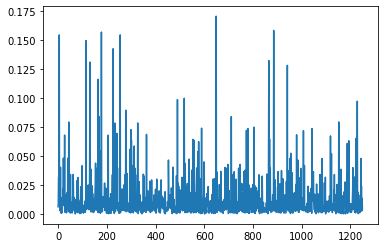

In [9]:
# Plot the losses
from matplotlib import pyplot as plt
plt.plot(losses)

  0%|          | 0/1000 [00:00<?, ?it/s]

1


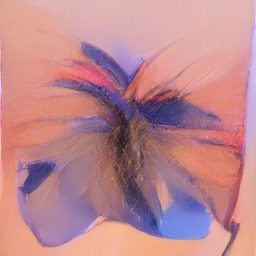

In [10]:
# Generate and view an image
images = image_pipe().images # Forward method does all the magic (slowly)
print(len(images))
images[0]

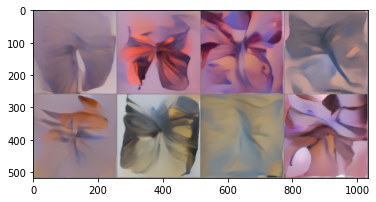

In [25]:
from diffusers import DDIMScheduler
import torchvision

# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_config("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

x = torch.randn(8, 3, 256, 256).to(device) # Batch of 8

for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5 + 0.5);

In [11]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

The config attributes {'variance_type': 'fixed_small'} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


0it [00:00, ?it/s]

0 loss: 3.9597525596618652
10 loss: 1.1187255382537842
20 loss: 0.914357602596283
30 loss: 0.8674078583717346


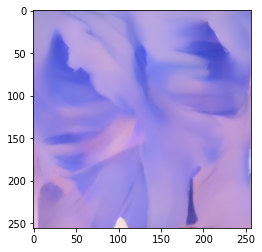

In [20]:
from diffusers import DDIMScheduler
import torchvision

# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_config("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

x = torch.randn(1, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]


    x = x.detach().requires_grad_()

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = blue_loss(x0) * 5
    if i%10==0:
        print(i, 'loss:', loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify the latents based on this gradient
    x = x.detach() + cond_grad # * sigma**2 # TODO should scale by something here for this to be 'correct'
    
    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample
    
plt.imshow(x[0].permute(1, 2, 0).cpu().clip(-1, 1)*0.5 + 0.5)

In [34]:
from PIL import Image
import numpy as np
im = grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5 + 0.5
Image.fromarray(np.array(im*155).astype(np.uint8)).save('butterflies_grid.png')